<a href="https://colab.research.google.com/github/nmermigas/PyTorch/blob/main/06_PyTorch_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Tansfer Learning

What is Transfer Learning?

Transfer learning invokes taking the parameters of what one model has learned and applying it to another dataset.

* Pretrained models = foundation models

In [1]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)


2.1.0+cu118
0.16.0+cu118


Downloading the going modular (05 notebook)

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 4036 (delta 1068), reused 1086 (delta 996), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.02 MiB | 15.89 MiB/s, done.
Resolving deltas: 100% (2361/2361), done.
Updating files: 100% (248/248), done.


In [3]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
!nvidia-smi

Mon Nov 20 20:48:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Get data

We need again the pizza, steak, shushi dataset to build our transfer model on.

In [5]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [6]:
# Setup directory path
train_dir = image_path /'train'
test_dir = image_path /'test'

train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

Now that we have the data, we can create DataLoaders.
We will use `data_setup.py`

Note: We need t think about **transforms** before loading.

There are two ways of doing that:

1. Manually created transforms - you define what transforms you want your data to go through.
2. Automatically created transforms - the transforms for your data are defined by the model you will use.

Important: When using a pretrained model, it is impotant that the data that you pass to it are transformed in the same way that the data the model was trained on.

In [7]:
from going_modular.going_modular import data_setup

### 2.1 Creating a transform for `torchvision.models` (manual creation)

`torchvision.models` contais pretrained models.

In [8]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0,229,0,224,0,225])

manual_transforms = transforms.Compose([
                                      transforms.Resize((224,224)), # resize image into 224 * 224
                                      transforms.ToTensor(), # get images into range[0,1]
                                      normalize]) # make sure images have the same distribution as ImageNet

In [9]:
from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               batch_size = 32,
                                                                               transform = manual_transforms
                                                                               )
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79a26a5f6260>,
 ['pizza', 'steak', 'sushi'])

## 2.2 Creating a transform for `torchvision.models` (auto creation)

As of `torchvision` latest versions, there is support for automatic data transform creation based on the pretrained model you are using.

In [10]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT = best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [11]:
# Get the transforms used to create our pretrained wwights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [12]:
# Create dataloders using the automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               batch_size = 32,
                                                                               transform = auto_transforms
                                                                               )
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x79a26a5f7b80>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various places to get a pretrained model, such as:
1. PyTorch domain libraries
2. Libraries like `tim` (torch image models)
3. HuggingFace hub
4. Paperswithcode

## 3.1 Which pretrained model should you use?

*Experiment, experiment, experiment!!!*

The whole idea of transfer learning: take an already well-performing model from a problem space similar to your own and then customize to  your own problem.

3 things to coonsider:
1. Speed - how fast does it  run?
2. Size - how big is the model?
3. Performance - how well does it go on your chosen problem?

Where does the model live? On the device or on a server?

We'll use EffNetB0 for our case (deploying FoodVision Mini on a mobile device)

## 3.2 Setting up a pretrained model
We want to create an instance of a pretrained EffNetB0

In [20]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B1_Weights.IMAGENET1K_V1
model = torchvision.models.efficientnet_b1(weights=weights).to(device)


#model # uncomment to output (it's very long)

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 185MB/s]


In [22]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

## 3.3 Getting a summary of the model with `torchinfo.summary()`

In [28]:
from torchinfo import summary

summary(model=model,
        input_size=(1,3,224,224),
        col_names=['input_size',"output_size","num_params",'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 3.4 Freezing the base model and changing the output layer to suit our needs

Typically, with a feature extraction model, we 'freeze' the base layers and just update the last layers (classifier).

In [25]:
for param in model.features.parameters():
  param.requires_grad = False

In [27]:
# Update the classifier head of our model
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2,inplace=True), # random dropping some neurons to prevent overfitting (with a probability p)
    nn.Linear(in_features=1280, # feature vector coming in
              out_features = len(class_names)) # how many classes do we have
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

## 4. Train the model

In [43]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)


In [44]:
# Import  train function
from going_modular.going_modular import engine

# Set the manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()
# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 5,
                       device = device)

# End the timer
end_time = timer()
print(f'[INFO] Total training time: {end_time - start_time:.3f}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0152 | train_acc: 0.9961 | test_loss: 0.3389 | test_acc: 0.8362
Epoch: 2 | train_loss: 0.0136 | train_acc: 1.0000 | test_loss: 0.2921 | test_acc: 0.8466
Epoch: 3 | train_loss: 0.0135 | train_acc: 1.0000 | test_loss: 0.2803 | test_acc: 0.8769
Epoch: 4 | train_loss: 0.0115 | train_acc: 1.0000 | test_loss: 0.2586 | test_acc: 0.9176
Epoch: 5 | train_loss: 0.0126 | train_acc: 1.0000 | test_loss: 0.2519 | test_acc: 0.8769
[INFO] Total training time: 13.252


## 5. Evaluate the model by plotting loss curvers

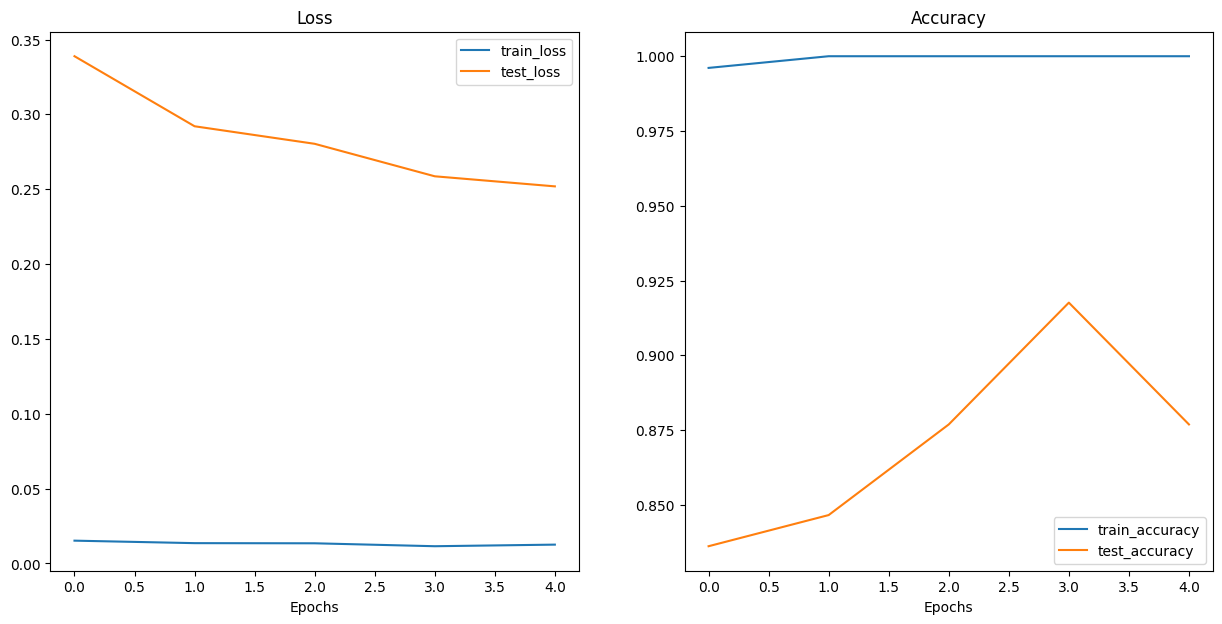

In [45]:
try:
  from helper_functions import plot_loss_curves
except:
  print("[INFO] Couldn't find helper_functions.py, downloading...")
  with open("helper_functions.py", "wb") as f:
      import requests
      request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
      f.write(request.content)
  from helper_functions import plot_loss_curves
plot_loss_curves(results)

## 6. Make predictions on images from the test set

Let's stick to the moto: visualize,visualize,visualize

And make some qualitative preds on the test set.

Some things to keep in mind when making predictions/inference on test data.custom data.

We have to make sure that our test/custom data is:
* Same shape - images need to be same shape as model was trained on
* Same datatype - custom data should be in the same data type
* Same device - custom data/test data shoud be in the same device as the model
* Same tranasform

To do all this automatically, let's write a function!

`pred_and_plot_image()`:

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open the image with `PIL.Image.Opne()`
3. Create a transform if one doesn't exist.
4. Make sure the model is on the righ t device.
5. Turn the model to `model.eval()` mode to make sure it's ready for inference. (this will turn of things like `nn.Dropout()`
6. Transform the target image and make sure its dimensionality is suited for the model (this mainly relates to the batch size)
7. Make a prediction on the image by passing to the model.
8. Convert the model's output logits to prediction probabilities using `torch.softmax()`
9. Convert model's prediction probabilities to prediction labels using `torch.argmax()`
10. Plot the image

In [55]:
from typing import List, Tuple

from PIL import Image

from torchvision import transforms

# 1. Take in the trained model

def pred_and_plot_image(model: torch.nn.Module,
                        image_path:str,
                        class_names: List[str],
                        image_size: Tuple[int,int] = (224,224),
                        transform: torchvision.transforms = None,
                        device: torch.device = device):
  # 2. Open the image
  img = Image.open(image_path)

  # 3. Create a transform if it doesnt exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
    ])


    #4. Model on target device
    model.to(device)

    # 5. inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform the image and add an extra batch dimension
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a pred on the tansformed image by passing it to the model
      target_image_pred = model(transformed_image.to(device))

      # 8. Convert the output from logits to pred probs
      target_image_pred_probs = torch.softmax(target_image_pred,dim=1)

      # 9. Convert the pred probs to pred labels
      target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

      # 10. Plot the image
      plt.figure()
      plt.imshow(img)
      plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")

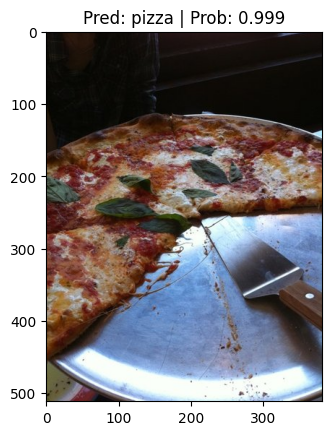

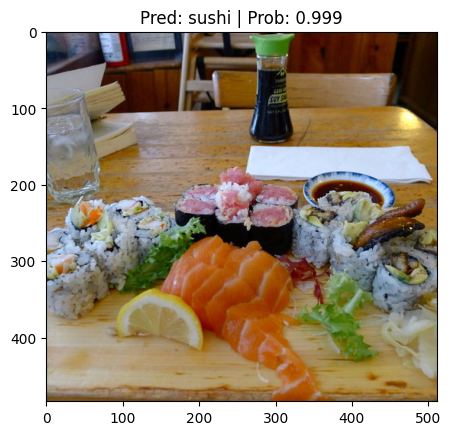

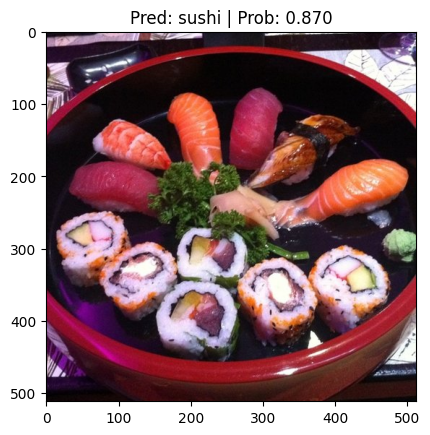

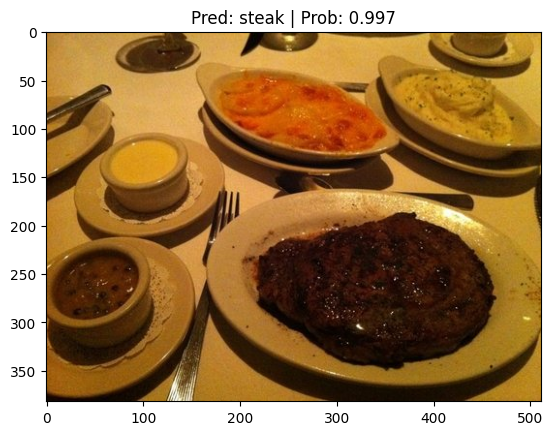

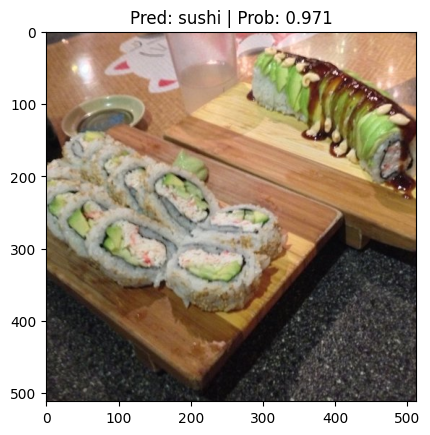

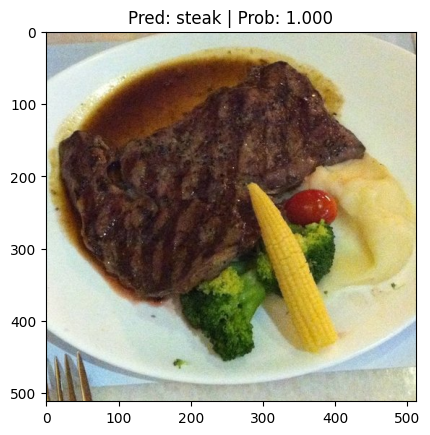

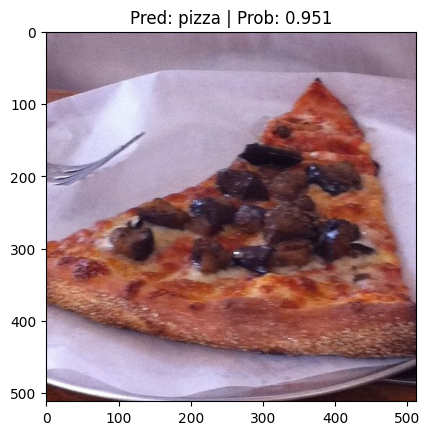

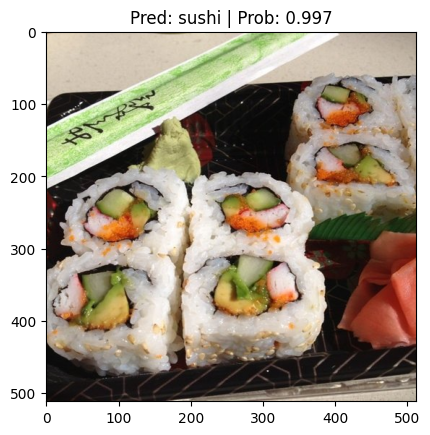

In [59]:
# Get a random list of image paths from the test set
import random
num_images = 8
test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))
test_image_path_sample = random.sample(population = test_image_path_list,
                                       k = num_images)

# Make predictions

for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224,224))

In [49]:
test_dir

PosixPath('data/pizza_steak_sushi/test')